In [1]:
from PIL import Image
from matplotlib import pyplot as plt

from backgroundsubtraction_module import *
from superpoint import *

In [2]:
backsub = BackgroundSubtraction()
fe = SuperPointFrontend(weights_path='superpoint_v1.pth',
                       nms_dist=4,
                       conf_thresh=0.015,
                       nn_thresh=0.7,
                       cuda=True)

In [3]:
from scipy.ndimage import rotate

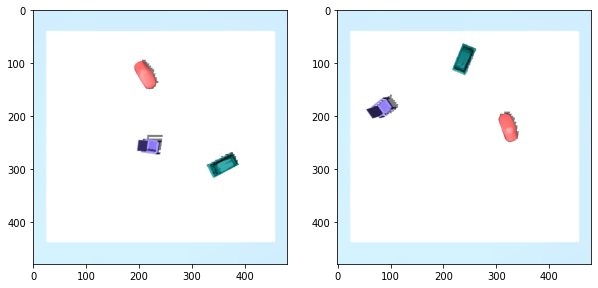

In [142]:
# descriptor w/o rotation #
img_idx = 109
img_s = np.array(Image.open('../object_wise/dqn/test_scenes/state/%d.png'%img_idx))
img_s[:40, 120:240] = [209, 238, 255]
img_s_gray = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)
img_s_gray = img_s_gray.astype(np.float32)/255.
pts_s, desc_s, heatmap_s = fe.run(img_s_gray)

img_idx = 109
img_g = np.array(Image.open('../object_wise/dqn/test_scenes/goal/%d.png'%img_idx))
img_g[:40, 120:240] = [209, 238, 255]
img_g_gray = cv2.cvtColor(img_g, cv2.COLOR_RGB2GRAY)
img_g_gray = img_g_gray.astype(np.float32)/255.
pts_g, desc_g, heatmap_g = fe.run(img_g_gray)

plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_s)
plt.subplot(1, 2, 2)
plt.imshow(img_g)

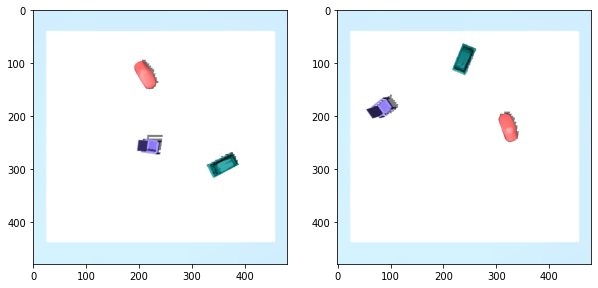

In [149]:
# descriptor with rotation #
img_idx = 109
img_s = np.array(Image.open('../object_wise/dqn/test_scenes/state/%d.png'%img_idx))
img_s[:40, 120:240] = [209, 238, 255]
img_s_gray = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)
img_s_gray = img_s_gray.astype(np.float32)/255.
pts_s, desc_s, heatmap_s = fe.run_rotate(img_s_gray)
desc_s = desc_s.max(0)
desc_s /= np.linalg.norm(desc_s, axis=0)

img_idx = 109
img_g = np.array(Image.open('../object_wise/dqn/test_scenes/goal/%d.png'%img_idx))
img_g[:40, 120:240] = [209, 238, 255]
img_g_gray = cv2.cvtColor(img_g, cv2.COLOR_RGB2GRAY)
img_g_gray = img_g_gray.astype(np.float32)/255.
pts_g, desc_g, heatmap_g = fe.run_rotate(img_g_gray)
desc_g = desc_g.max(0)
desc_g /= np.linalg.norm(desc_g, axis=0)

plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_s)
plt.subplot(1, 2, 2)
plt.imshow(img_g)

img_idx = 109
img_s = np.array(Image.open('../object_wise/dqn/test_scenes/state/%d.png'%img_idx))
img_s[:40, 120:240] = [209, 238, 255]
img_s_gray = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)
img_s_gray = img_s_gray.astype(np.float32)/255.
pts_s, desc_s, heatmap_s = fe.run(img_s_gray)
for theta in range(8):
    _pts, _desc, _heatmap = fe.run(rotate(img_s_gray, angle=45*theta, reshape=True))
    _heatmap = rotate(_heatmap, angle=-45*theta, reshape=True)
    h, w = _heatmap.shape
    _heatmap_crop = _heatmap[h//2-240:h//2+240, w//2-240: w//2+240]
#     plt.imshow(_heatmap_crop)
#     plt.show()
    #print((_pts.T).astype(int))
    
    th = 45 * theta * np.pi / 180
    #R = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])
    R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    print(np.dot(R, (_pts[:2] - np.array([[240], [240]]))) + np.array([[240], [240]]))
    _pts_rotated = np.dot(R, (_pts[:2] - np.array([[240], [240]]))) + np.array([[240], [240]])
    for pt in _pts_rotated.T:
        cv2.circle(_heatmap_crop, tuple(pt.astype(int)), 4, (1, 1, 1))
        
    plt.imshow(_heatmap_crop)
    plt.show()

img_idx = 109
img_s = np.array(Image.open('../object_wise/dqn/test_scenes/state/%d.png'%img_idx))
img_s[:40, 120:240] = [209, 238, 255]
img_s_gray = cv2.cvtColor(img_s, cv2.COLOR_RGB2GRAY)
img_s_gray = img_s_gray.astype(np.float32)/255.
pts_s, desc_s, heatmap_s = fe.run(img_s_gray)
# for theta in range(8):
#     _pts, _desc, _heatmap = fe.run(rotate(img_s_gray, angle=45*theta, reshape=True))
#     _heatmap = rotate(_heatmap, angle=-45*theta, reshape=True)
#     h, w = _heatmap.shape
#     plt.imshow(_heatmap[h//2-240:h//2+240, w//2-240: w//2+240])
#     plt.show()
#     print((_pts.T).astype(int))

img_g = np.array(Image.open('../object_wise/dqn/test_scenes/goal/%d.png'%img_idx))
img_g[:40, 120:240] = [209, 238, 255]
img_g_gray = cv2.cvtColor(img_g, cv2.COLOR_RGB2GRAY)
img_g_gray = img_g_gray.astype(np.float32)/255.
pts_g, desc_g, heatmap_g = fe.run(img_g_gray)

plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_s)
plt.subplot(1, 2, 2)
plt.imshow(img_g)

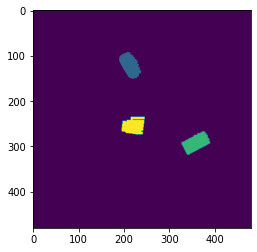

In [143]:
masks_s, colors_s, fmask_s = backsub.get_masks(img_s, 3)
masks_g, colors_g, fmask_g = backsub.get_masks(img_g, 3)

segm_s = np.zeros_like(fmask_s).astype(int)
for m, mask in enumerate(masks_s):
    mask_blur = cv2.blur(mask, (3, 3)).astype(bool).astype(int)
    segm_s += mask_blur * (m+1)

segm_g = np.zeros_like(fmask_g).astype(int)
for m, mask in enumerate(masks_g):
    mask_blur = cv2.blur(mask, (3, 3)).astype(bool).astype(int)
    segm_g += mask_blur * (m+1)

plt.imshow(segm_s)

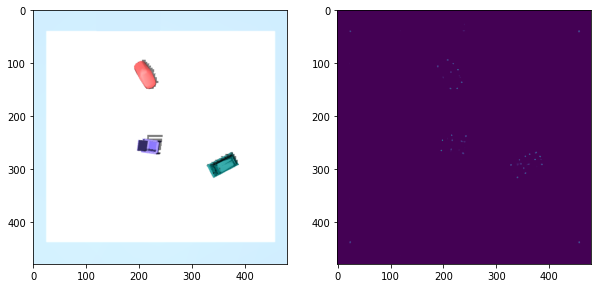

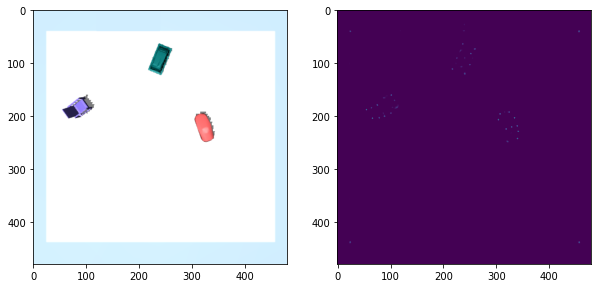

In [144]:
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_s)
plt.subplot(1, 2, 2)
plt.imshow(heatmap_s)


plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_g)
plt.subplot(1, 2, 2)
plt.imshow(heatmap_g)

In [145]:
def match_descriptor(desc1, desc2, nn_thresh=0.7):
    dmat = np.dot(desc1.T, desc2)
    dmat = np.sqrt(2 - 2*np.clip(dmat, -1, 1))
    
    idx = np.argmin(dmat, axis=1)
    scores = dmat[np.arange(dmat.shape[0]), idx]
    keep = scores < nn_thresh
    
    idx2 = np.argmin(dmat, axis=0)
    keep_bi = np.arange(len(idx))
    
    keep = np.logical_and(keep, keep_bi)
    idx = idx[keep]
    scores = scores[keep]
    
    m_idx1 = np.arange(desc1.shape[1])[keep]
    m_idx2 = idx
    
    matches = np.zeros((3, int(keep.sum())))
    matches[0, :] = m_idx1
    matches[1, :] = m_idx2
    matches[2, :] = scores
    
    return matches

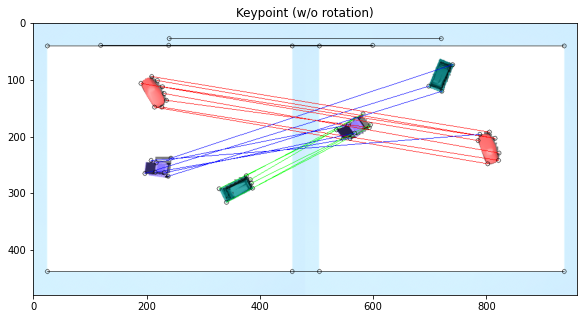

In [146]:
matches = match_descriptor(desc_s, desc_g, 0.8)
id1, id2, score = matches

pts_s_matched = pts_s.T[id1.astype(int)]
pts_g_matched = pts_g.T[id2.astype(int)]

plt.figure(figsize=(15,5))
result = np.zeros([480, 480*2, 3])
result[:, :480] = img_s/255.
result[:, 480:] = img_g/255.

cmap = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)]

for m in range(len(score)):
    pt_s = pts_s_matched[m]
    pt_g = pts_g_matched[m]
    
    x, y = pt_s[:2].astype(int)
    seg_id = segm_s[y, x]
    
    cv2.circle(result, tuple(pt_s[:2].astype(int)), 4, (0, 0, 0))
    cv2.circle(result, tuple(pt_g[:2].astype(int) + [480, 0]), 4, (0, 0, 0))
    cv2.line(result, tuple(pt_s[:2].astype(int)), tuple(pt_g[:2].astype(int) + [480, 0]), cmap[seg_id])
    
plt.title('Keypoint (w/o rotation)')    
plt.imshow(result)

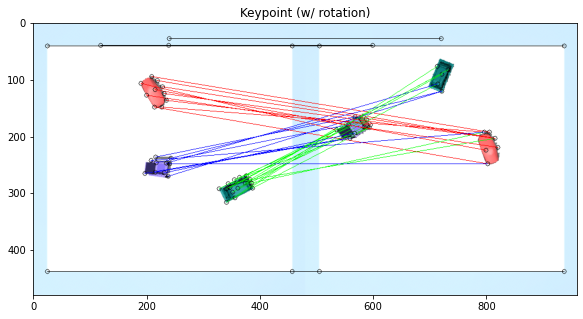

In [150]:
matches = match_descriptor(desc_s, desc_g, 0.8)
id1, id2, score = matches

pts_s_matched = pts_s.T[id1.astype(int)]
pts_g_matched = pts_g.T[id2.astype(int)]

plt.figure(figsize=(15,5))
result = np.zeros([480, 480*2, 3])
result[:, :480] = img_s/255.
result[:, 480:] = img_g/255.

cmap = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)]

for m in range(len(score)):
    pt_s = pts_s_matched[m]
    pt_g = pts_g_matched[m]
    
    x, y = pt_s[:2].astype(int)
    seg_id = segm_s[y, x]
    
    cv2.circle(result, tuple(pt_s[:2].astype(int)), 4, (0, 0, 0))
    cv2.circle(result, tuple(pt_g[:2].astype(int) + [480, 0]), 4, (0, 0, 0))
    cv2.line(result, tuple(pt_s[:2].astype(int)), tuple(pt_g[:2].astype(int) + [480, 0]), cmap[seg_id])
    
plt.title('Keypoint (w/ rotation)')    
plt.imshow(result)

## ResNet

In [86]:
import copy
import torchvision.models as models
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix

In [108]:
resnet50 = models.resnet50(pretrained=True).to("cuda")

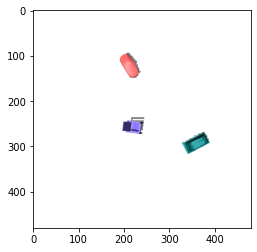

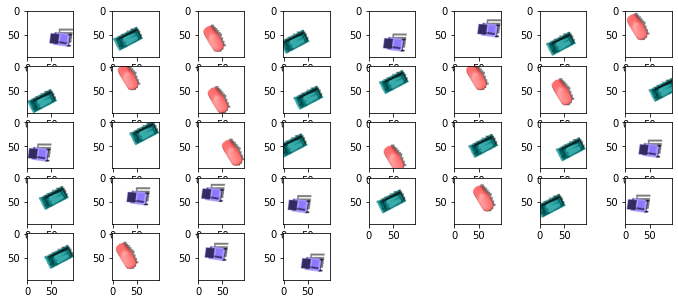

In [151]:
size = 48 #32

# resnet feature for points in s #
segment_image = copy.deepcopy(img_s)
segment_image[fmask_s==0] = [255, 255, 255]
plt.imshow(segment_image)

fig=plt.figure(figsize=(12,7))

local_patches = []
m = 0
for i in range(len(pts_s.T)):
    pt_s = pts_s.T[i]
    mx, my = pt_s[:2].astype(int)
    if mx < size or my < size or mx > 480-size or my > 480-size:
        continue
    
    local_patch = segment_image[my-size:my+size, mx-size:mx+size]
    local_patches.append(local_patch.transpose([2, 0, 1]))
    
    ax = fig.add_subplot(len(pts_s.T)//6, len(pts_s.T)//6 + 1, m + 1)
    ax.imshow(local_patch)
    m += 1
    
inputs = torch.Tensor(local_patches).to("cuda")
f_resnet_s = resnet50(inputs).cpu().detach().numpy()

# resnet feature for points in g #
segment_image = copy.deepcopy(img_g)
segment_image[fmask_g==0] = [255, 255, 255]

local_patches = []
for m in range(len(pts_g.T)):
    pt_g = pts_g.T[m]
    mx, my = pt_g[:2].astype(int)
    if mx < size or my < size or mx > 480-size or my > 480-size:
        continue
    
    local_patch = segment_image[my-size:my+size, mx-size:mx+size]
    local_patches.append(local_patch.transpose([2, 0, 1]))
    
inputs = torch.Tensor(local_patches).to("cuda")
f_resnet_g = resnet50(inputs).cpu().detach().numpy()

In [84]:
def match_features(features_src, features_dest, threshold=1.0):
    src_norm = features_src / 100.
    dest_norm = features_dest / 100.
    #src_norm = features_src / np.linalg.norm(features_src, axis=1).reshape(-1, 1)
    #dest_norm = features_dest / np.linalg.norm(features_dest, axis=1).reshape(-1, 1)
    dist_mat = distance_matrix(dest_norm, src_norm)
    #dist_mat[dist_mat < threshold] = dist_mat.min()
    idx_dest, idx_src = linear_sum_assignment(dist_mat)
    
    scores = dist_mat[idx_dest, idx_src]
    keep = np.where(scores>threshold)
    
    idx_src = idx_src[keep]
    idx_dest = idx_dest[keep]
    scores = scores[keep]
    
    return idx_src, idx_dest, scores

[0.70003519 0.84662002 0.71048491 0.73536446 0.88375099 0.71816365
 0.78598947 0.75722259 0.90578598 0.84074537 0.75904516 0.74181038
 1.03793791 0.8349408  0.75579041 0.8476629  0.73180362 1.05824228
 0.79000077 0.81408929 0.84056421 0.75096101 0.70300905 1.07110781
 0.8240943  0.72100047 0.78870861]


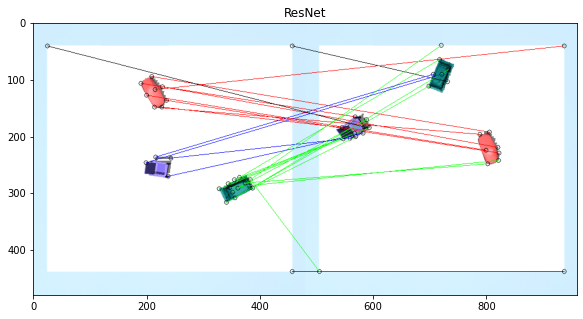

In [152]:
matches = match_features(f_resnet_s, f_resnet_g, 0.7)
id1, id2, scores = matches
print(scores)

pts_s_matched = pts_s.T[id1.astype(int)]
pts_g_matched = pts_g.T[id2.astype(int)]

plt.figure(figsize=(15,5))
result = np.zeros([480, 480*2, 3])
result[:, :480] = img_s/255.
result[:, 480:] = img_g/255.

cmap = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)]

for m in range(len(id1)):
    pt_s = pts_s_matched[m]
    pt_g = pts_g_matched[m]
    
    x, y = pt_s[:2].astype(int)
    seg_id = segm_s[y, x]
    
    cv2.circle(result, tuple(pt_s[:2].astype(int)), 4, (0, 0, 0))
    cv2.circle(result, tuple(pt_g[:2].astype(int) + [480, 0]), 4, (0, 0, 0))
    cv2.line(result, tuple(pt_s[:2].astype(int)), tuple(pt_g[:2].astype(int) + [480, 0]), cmap[seg_id])
    
    
plt.title('ResNet')
plt.imshow(result)

## CLIP

In [62]:
import copy
import clip

In [63]:
model, preprocess = clip.load("ViT-B/32", device="cuda")

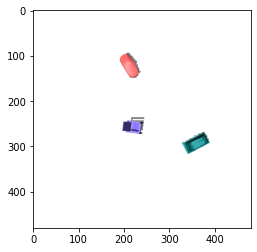

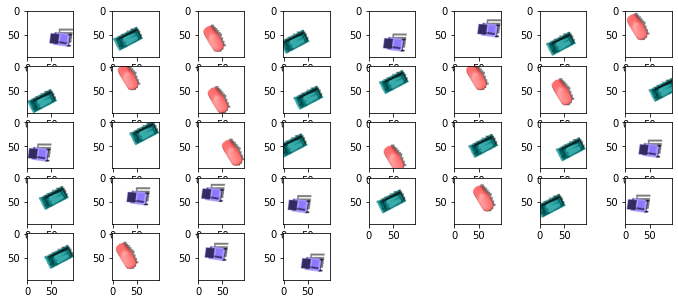

In [153]:
size = 48 #32

# CLIP feature for points in s #
segment_image = copy.deepcopy(img_s)
segment_image[fmask_s==0] = [255, 255, 255]
plt.imshow(segment_image)

fig=plt.figure(figsize=(12,7))

local_patches = []
m = 0
for i in range(len(pts_s.T)):
    pt_s = pts_s.T[i]
    mx, my = pt_s[:2].astype(int)
    if mx < size or my < size or mx > 480-size or my > 480-size:
        continue
    
    local_patch = segment_image[my-size:my+size, mx-size:mx+size]
    processed_patch = preprocess(Image.fromarray(local_patch))
    local_patches.append(np.array(processed_patch))
    
    ax = fig.add_subplot(len(pts_s.T)//6, len(pts_s.T)//6 + 1, m + 1)
    ax.imshow(local_patch)
    m += 1
    
inputs = torch.Tensor(local_patches).to("cuda")
f_clip_s = model.encode_image(inputs).cpu().detach().numpy()
f_clip_s /= np.linalg.norm(f_clip_s, axis=0)

# CLIP feature for points in g #
segment_image = copy.deepcopy(img_g)
segment_image[fmask_g==0] = [255, 255, 255]

local_patches = []
for m in range(len(pts_g.T)):
    pt_g = pts_g.T[m]
    mx, my = pt_g[:2].astype(int)
    if mx < size or my < size or mx > 480-size or my > 480-size:
        continue
    
    local_patch = segment_image[my-size:my+size, mx-size:mx+size]
    processed_patch = preprocess(Image.fromarray(local_patch))
    local_patches.append(np.array(processed_patch))
    
inputs = torch.Tensor(local_patches).to("cuda")
f_clip_g = model.encode_image(inputs).cpu().detach().numpy()
f_clip_g /= np.linalg.norm(f_clip_g, axis=0)

[0.03195113 0.0298059  0.02239022 0.02302457 0.02923935 0.02254458
 0.03395363 0.03092543 0.02275735 0.02387563 0.02808274 0.02487593
 0.0278141  0.02628564 0.03444394 0.02690133 0.0317547  0.02924082
 0.02014635 0.03384411 0.02461436 0.02869887 0.02517965 0.02926704
 0.02370708 0.03047804 0.03279421 0.02429583 0.02773104]


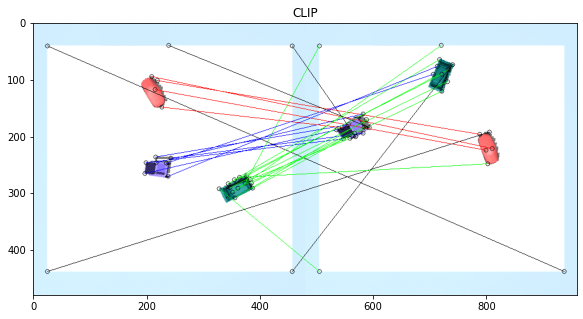

In [154]:
matches = match_features(f_clip_s, f_clip_g, 0.02)
id1, id2, scores = matches
print(scores)

pts_s_matched = pts_s.T[id1.astype(int)]
pts_g_matched = pts_g.T[id2.astype(int)]

plt.figure(figsize=(15,5))
result = np.zeros([480, 480*2, 3])
result[:, :480] = img_s/255.
result[:, 480:] = img_g/255.

cmap = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)]

for m in range(len(id1)):
    pt_s = pts_s_matched[m]
    pt_g = pts_g_matched[m]
    
    x, y = pt_s[:2].astype(int)
    seg_id = segm_s[y, x]
    
    cv2.circle(result, tuple(pt_s[:2].astype(int)), 4, (0, 0, 0))
    cv2.circle(result, tuple(pt_g[:2].astype(int) + [480, 0]), 4, (0, 0, 0))
    cv2.line(result, tuple(pt_s[:2].astype(int)), tuple(pt_g[:2].astype(int) + [480, 0]), cmap[seg_id])
    
    
plt.title('CLIP')
plt.imshow(result)

## CPD

In [ ]:
reg = RigidPartRegistration(**{'X': points_s, 'Y': points_g, 'Z': z_g, 'RGB': RGB, 'HSV': HSV, 'K': num_obj})
TY, (R, t) = reg.register(callback)

## UCN

In [5]:
import sys
file_path = '/home/gun/Desktop/ur5_manipulation/keypoint'
sys.path.append(os.path.join(file_path, '..', 'UnseenObjectClustering'))
import networks
from fcn.test_dataset import clustering_features
from fcn.config import cfg_from_file

In [6]:
ckpt_path = os.path.join(file_path, '../', 'UnseenObjectClustering', \
        'experiments/checkpoints/seg_resnet34_8s_embedding_cosine_color_sampling_epoch_16.checkpoint.pth')
cfg = os.path.join(file_path, '../', 'UnseenObjectClustering', \
        'experiments/cfgs/seg_resnet34_8s_embedding_cosine_color_tabletop.yml')

network_name = 'seg_resnet34_8s_embedding'
network_data = torch.load(ckpt_path)
network = networks.__dict__[network_name](2, 64, network_data).to("cuda")
_ = network.eval()

SEGNET(
  (embedding_loss): EmbeddingLoss()
  (fcn): Resnet34_8s(
    (resnet34_8s): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),

In [ ]:
rgb = img_s.transpose([2, 0, 1]).astype(float)/255.
rgb_tensor = torch.tensor(rgb, dtype=torch.float32).unsqueeze(0).to("cuda")
features = network(rgb_tensor, None, None).detach()